<a href="https://colab.research.google.com/github/tombackert/ml-stuff/blob/main/mnist_grad_cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Image classification using CNN + Grad-CAM Visualization

In [19]:
import numpy as np
import tensorflow as tf
import keras

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from keras.applications import Xception
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import to_categorical
from keras import backend as K

# Display
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Image, display

In [2]:
# model
def create_mnist_model():
  inputs = Input(shape=(28, 28, 1))
  x = Conv2D(32, (3, 3), activation='relu')(inputs)
  x = MaxPooling2D((2, 2))(x)
  x = Flatten()(x)
  x = Dense(64, activation='relu')(x)
  outputs = Dense(10, activation='softmax')(x)
  model = Model(inputs=inputs, outputs=outputs)
  return model


In [3]:
# Load and Preprocess MNIST Data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Reshape for compatibility with 2D convolutional layers
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)


11490434/11490434 [==============================] - 1s 0us/step


In [5]:
# train the model
model = create_mnist_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))


Epoch 1/5
1875/1875 [==============================] - 45s 23ms/step - loss: 0.1660 - accuracy: 0.9499 - val_loss: 0.0741 - val_accuracy: 0.9757
Epoch 2/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0583 - accuracy: 0.9817 - val_loss: 0.0574 - val_accuracy: 0.9807
Epoch 3/5
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0398 - accuracy: 0.9875 - val_loss: 0.0487 - val_accuracy: 0.9842
Epoch 4/5
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0269 - accuracy: 0.9918 - val_loss: 0.0404 - val_accuracy: 0.9864
Epoch 5/5
1875/1875 [==============================] - 35s 18ms/step - loss: 0.0190 - accuracy: 0.9941 - val_loss: 0.0427 - val_accuracy: 0.9868


In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 5408)              0         
                                                                 
 dense (Dense)               (None, 64)                346176    
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                             

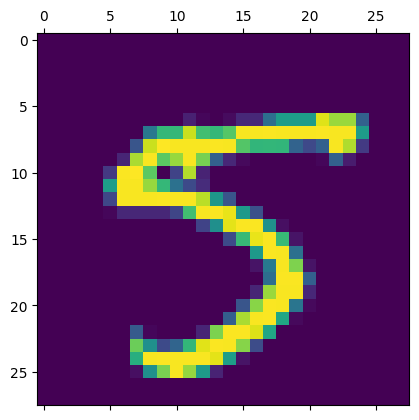

In [14]:
# test image for grad-cam
test_image = x_test[102]
test_image_array = test_image
test_image = test_image.reshape(28, 28)
test_image = (test_image * 255).astype(np.uint8)

test_image = Image.fromarray(test_image, mode="L")
test_image.save('test_image.png')
img_path = 'test_image.png'

plt.matshow(test_image_array)
plt.show()

In [11]:
# parameters
img_size = (28, 28)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = 'conv2d'

img_path = img_path

In [15]:
# Grad-CAM algorithm

def get_img_array(img_path, size):
    # `img` is a PIL image of size 28x28
    img = keras.utils.load_img(img_path, target_size=size, color_mode = "grayscale") # grayscale for shape (x, y, 1)
    # `array` is a float32 Numpy array of shape (299, 299, 1)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


1/1 [==============================] - 0s 22ms/step
Predicted: [[-58.094894   40.775734  -29.347956  -27.967087  -53.72618    54.754627
  -82.46918    -3.3332877 -38.577522  -41.260597 ]]


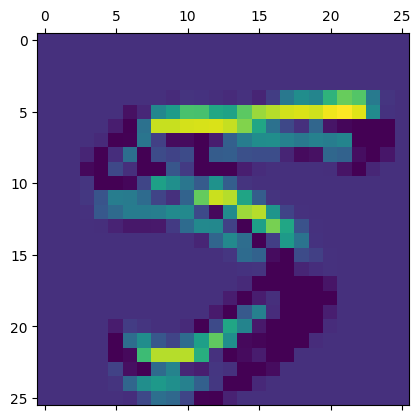

In [16]:
# test-drive

# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size)) # we want

# Make model
model = model

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds)

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()


In [192]:
heatmap.shape

(26, 26)

<Figure size 640x480 with 0 Axes>

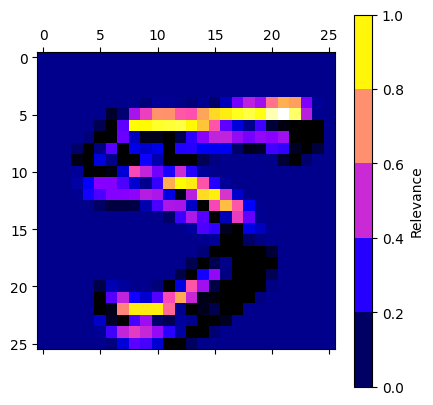

In [17]:
# create visualization

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    colormap = mpl.colormaps["gnuplot2"]

    # Use RGB values of the colormap
    colormap_colors = colormap(np.arange(256))[:, :3]
    colormap_heatmap = colormap_colors[heatmap]

    plt.figure()
    plt.matshow(colormap_heatmap)
    plt.colorbar(mpl.cm.ScalarMappable(cmap=colormap), label="Relevance", boundaries=np.linspace(0, 1, 6), ax=plt.gca())
    plt.show()

save_and_display_gradcam(img_path, heatmap)